# Task 2: Credit card detection

- Develop a machine learning model designed to detect fraudulent credit card
transactions.

- The process involves preprocessing and normalizing transaction data, addressing class imbalance concerns, and partitioning the dataset into training and testing subsets.

- Train a classification algorithm—like logistic regression or random forests—to
differentiate between fraudulent and legitimate transactions.

- Assess the model's efficacy using metrics such as precision, recall, and F1-score.

- Additionally, explore strategies like oversampling or undersampling to enhance
outcomes and refine the model's performance.

# Credit Card Fraud Detection Dataset

## Overview
This dataset comprises anonymized credit card transactions, each labeled as either fraudulent or genuine. The primary aim is to facilitate the detection of fraudulent credit card transactions to prevent customers from being charged for unauthorized purchases.

## Context
Credit card companies rely on robust fraud detection mechanisms to safeguard customers from fraudulent transactions. Detecting and preventing fraudulent activities is crucial for maintaining trust and security in financial transactions.

## Content
- The dataset contains credit card transactions made by European cardholders in September 2013.
- Transactions span over two days, with a total of 284,807 transactions.
- Among these transactions, there are 492 instances of fraud.
- The dataset exhibits significant class imbalance, with fraudulent transactions accounting for only 0.172% of the total.
- Features include numerical inputs resulting from a Principal Component Analysis (PCA) transformation. However, due to confidentiality constraints, the original features and additional background information are not provided.
- Features V1 to V28 represent principal components obtained through PCA, while 'Time' and 'Amount' are original features.
- The 'Time' feature denotes the elapsed time in seconds between each transaction and the first transaction in the dataset.
- The 'Amount' feature indicates the transaction amount.
- The response variable, 'Class', takes a value of 1 for fraudulent transactions and 0 otherwise.

## Recommendations
- Given the class imbalance, it's advisable to evaluate model performance using metrics such as the Area Under the Precision-Recall Curve (AUPRC).
- Accuracy metrics derived from a confusion matrix may not be meaningful due to the imbalance in class distribution.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install ydata-profiling --quiet
# from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA

%matplotlib inline

Retrieving data from Kaggle API

In [45]:
# Local PC data retrieving
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
api.dataset_download_files('mlg-ulb/creditcardfraud', path='D:/Estiven/Datos/Proyectos/CognoRise_Infotech/data/raw', unzip=True)

# Read the data as a pandas dataframe
df = pd.read_csv("D:/Estiven/Datos/Proyectos/CognoRise_Infotech/data/raw/creditcard.csv")

In [46]:
# # Google Colab data retrieving
# from google.colab import files

# # Uploading the Kaggle API key (kaggle.json) to Colab
# files.upload()

# # Move the uploaded file to the required location of Colab
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d mlg-ulb/creditcardfraud #dataset download
# !unzip -q creditcardfraud.zip #unzipping the data

# df = pd.read_csv("creditcard.csv") #reading data as pandas dataframe

Separating the dataframe into the slices I will use to analyze the data and undertand it

In [47]:
data_3_principal = df[['Time', 'Amount', 'Class']]
fraudulent_transactions = df[df['Class'] == 1]
not_fraudulent_transactions = df[df['Class'] == 0]

Profile report of the dataset, overview and relationships between Time, Amount and Class variables

In [48]:
# pf_3_variables = ProfileReport(data_3_principal)
# pf_3_variables

In [49]:
# pf_fraudulent_trans = ProfileReport(fraudulent_transactions[['Time', 'Amount']])
# pf_fraudulent_trans

# EDA, (Exploratory data analysis)

Information about nulls, infinite values and duplicates

In [50]:
inf_values = np.isinf(df)
inf_rows, inf_cols = np.where(inf_values)

nulls = df.isnull()
null_rows, null_cols = np.where(nulls)

print(f'Total of null data: {df.isnull().sum().sum()}')
print(f'Total of duplicated data: {df.duplicated().sum()}')

print(f'Rows with null values: {null_rows.sum()}')
print(f'Columns with null values: {null_cols.sum()}')

print(f'Rows with inf values: {inf_rows.sum()}')
print(f'Columns with inf values: {inf_cols.sum()}')

Total of null data: 0
Total of duplicated data: 1081
Rows with null values: 0
Columns with null values: 0
Rows with inf values: 0
Columns with inf values: 0


Duplicates treatment, four percent of the data of Class1 are duplicate rows so I decide to eliminate all those rows to not interfere in the following analysis and ML model

In [51]:
duplicated_rows = df.duplicated()
duplicated_class_1_rows = duplicated_rows & (df['Class'] == 1)

print(f'Percentage of total duplicated data: {duplicated_rows.mean() * 100:.1f}%')
print(f'Total duplicates of the Class 1: {duplicated_class_1_rows.sum()}')
print(f'Percentage of duplicates of Class 1: {duplicated_class_1_rows.sum() / df["Class"].sum() * 100:.1f}%')

# Eliminating duplicated data
df = df.copy().drop_duplicates()

Percentage of total duplicated data: 0.4%
Total duplicates of the Class 1: 19
Percentage of duplicates of Class 1: 3.9%


In [52]:
print(f'Data description: \n{df.describe()}')

Data description: 
                Time             V1             V2             V3  \
count  283726.000000  283726.000000  283726.000000  283726.000000   
mean    94811.077600       0.005917      -0.004135       0.001613   
std     47481.047891       1.948026       1.646703       1.508682   
min         0.000000     -56.407510     -72.715728     -48.325589   
25%     54204.750000      -0.915951      -0.600321      -0.889682   
50%     84692.500000       0.020384       0.063949       0.179963   
75%    139298.000000       1.316068       0.800283       1.026960   
max    172792.000000       2.454930      22.057729       9.382558   

                  V4             V5             V6             V7  \
count  283726.000000  283726.000000  283726.000000  283726.000000   
mean       -0.002966       0.001828      -0.001139       0.001801   
std         1.414184       1.377008       1.331931       1.227664   
min        -5.683171    -113.743307     -26.160506     -43.557242   
25%        -0.

In [53]:
percentage_data_by_class = df['Class'].value_counts(normalize=True)
print(f'Percentage of data by class: \n{percentage_data_by_class}')

Percentage of data by class: 
Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64


In [54]:
# Full distribution analysis
from scipy import stats
def calculate_stats(data: pd.DataFrame) -> list:
    """
    Calculate the mean, standard deviation, skewness, and kurtosis for each column in a DataFrame.

    Parameters:
    data (pd.DataFrame): The DataFrame for which to calculate statistics.

    Returns:
    mean (list): The mean of each column.
    std (list): The standard deviation of each column.
    skewness (list): The skewness of each column.
    kurtosis (list): The kurtosis of each column.
    """

    # Initialize lists to store results
    mean, std, skewness, kurtosis = [], [], [], []

    for column in data.columns:
        mean.append(data[column].mean())
        std.append(data[column].std())
        skewness.append(stats.skew(data[column]))
        kurtosis.append(stats.kurtosis(data[column]))

    # Return the calculated statistics
    return mean, std, skewness, kurtosis


#Usage of the function in the original data
mean, std, skewness, kurtosis = calculate_stats(df)

stats_data = pd.DataFrame({'Column': df.columns,
                         'Mean': mean,
                         'Std': std,
                         'Skewness': skewness,
                         'Kurtosis': kurtosis})
stats_data

,Column,Mean,Std,Skewness,Kurtosis
0,Time,94811.077600,47481.047891,-0.035580,-1.293431
1,V1,0.005917,1.948026,-3.273254,32.726735
2,V2,-0.004135,1.646703,-4.695137,96.896444
3,V3,0.001613,1.508682,-2.151973,25.186065
4,V4,-0.002966,1.414184,0.671501,2.618712
5,V5,0.001828,1.377008,-2.414066,209.273758
6,V6,-0.001139,1.331931,1.829871,42.838110
7,V7,0.001801,1.227664,2.890256,414.134868
8,V8,-0.000854,1.179054,-8.310926,215.013122
9,V9,-0.001596,1.095492,0.537660,3.516578


There are not correlations between variables grater or equal than 0.7, but there is one grater or equal than 0.5, which is between `Amount` and `V2`



In [55]:
corr = df.corr()

# Filtering correlations
high_corr_variables = set()
correlation_value = 0.5
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) >= correlation_value:
            high_corr_variables.add(corr.columns[i])
            high_corr_variables.add(corr.columns[j])

print(f"Variables with a correlation greater than {correlation_value}:")
print(high_corr_variables)

Variables with a correlation greater than 0.5:
{'V2', 'Amount'}


In [56]:
# # Distribution of features
# features = df.drop(['Time', 'Amount', 'Class'], axis=1).columns
# plt.figure(figsize=(15, 15))

# for i, feature in enumerate(features, 1):
#     plt.subplot(6, 5, i)
#     sns.kdeplot(df[feature], color='darkblue')
#     plt.grid(True, alpha=0.5)
#     plt.title(f'Distribution of {feature}', fontsize=10)

# plt.suptitle('Features distribution', fontsize=16, y=1.02)
# plt.tight_layout()
# plt.show()

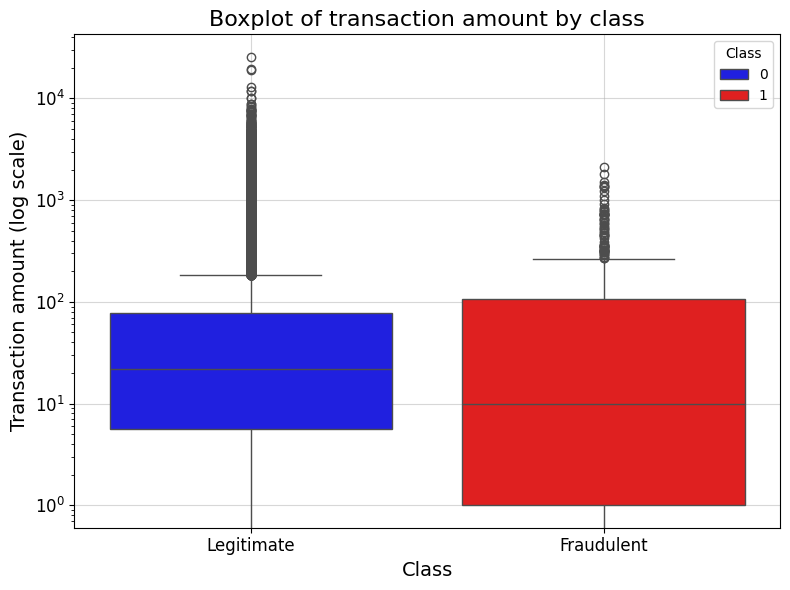

In [57]:
# Distribution of the 'Amount' feature
plt.figure(figsize=(8, 6))

# Create the boxplot with distinct colors for each class
sns.boxplot(x='Class', y='Amount', data=df, hue='Class', palette=['blue', 'red'])

# Add labels and title
plt.title('Boxplot of transaction amount by class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Transaction amount (log scale)', fontsize=14)
plt.xticks([0, 1], ['Legitimate', 'Fraudulent'], fontsize=12)
plt.yticks(fontsize=12)

plt.yscale('log') # Use a log scale for the y-axis
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

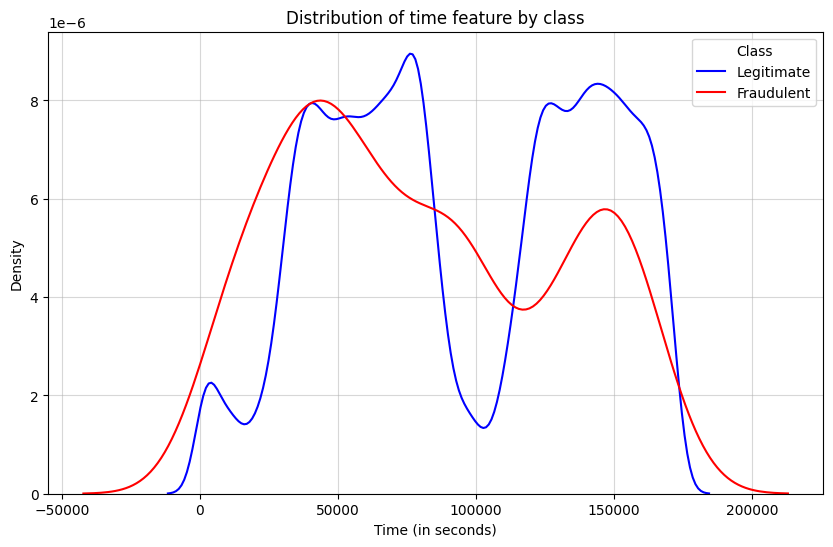

In [58]:
# Density plots for the 'Time' feature by class
plt.figure(figsize=(10, 6))

sns.kdeplot(df[df['Class'] == 0]['Time'], color='blue', label='Legitimate')
sns.kdeplot(df[df['Class'] == 1]['Time'], color='red', label='Fraudulent')

# Add labels and title
plt.xlabel('Time (in seconds)')
plt.ylabel('Density')
plt.title('Distribution of time feature by class')
plt.legend(title='Class')
plt.grid(True, alpha=0.5)

plt.show()

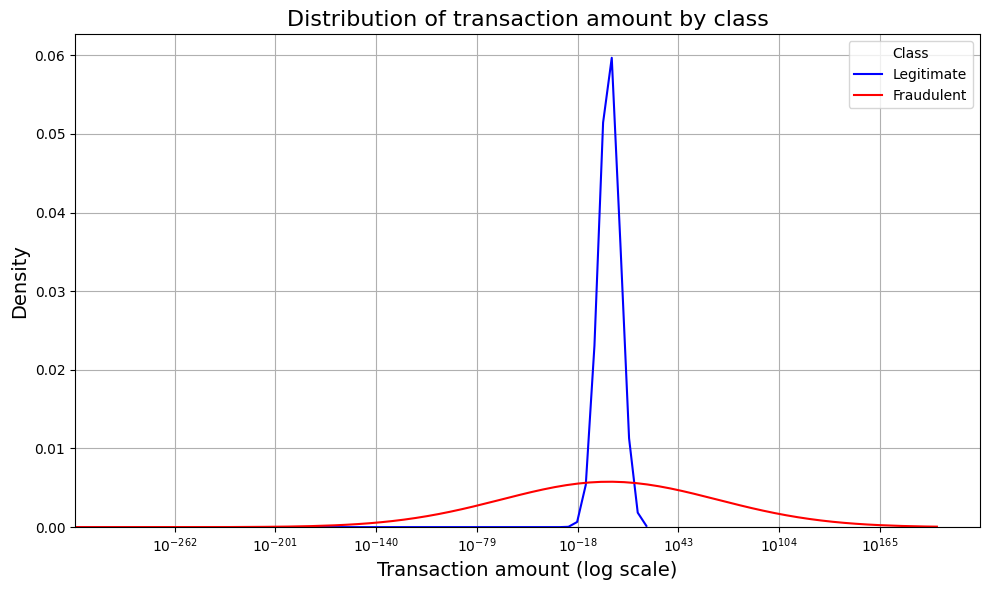

In [59]:
plt.figure(figsize=(10, 6))

plt.xscale('log') # Use a log scale for the y-axis
# Use density plots instead of histograms
sns.kdeplot(df[df['Class'] == 0]['Amount'], color='blue', label='Legitimate')
sns.kdeplot(df[df['Class'] == 1]['Amount'], color='red', label='Fraudulent')

# Add a grid
plt.grid(True)

# Add labels and title
plt.title('Distribution of transaction amount by class', fontsize=16)
plt.xlabel('Transaction amount (log scale)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Class')

plt.tight_layout()
plt.show()

Imbalaced data traetment, (three different methods)

In [60]:
from imblearn.over_sampling import SMOTE

def handle_imbalanced_data(dataset: pd.DataFrame, method: str='over_sampling'):
    """
    Handle imbalanced data in a dataset.

    Parameters:
    dataset (DataFrame): The input dataset which is imbalanced.
    method (str): The method to handle imbalanced data. It can be 'over_sampling', 'under_sampling', 'smote'. Default is 'over_sampling'.

    Returns:
    DataFrame: The balanced dataset.
    """
    # Get the counts of each class
    count_class_0, count_class_1 = dataset.Class.value_counts()

    # Divide the dataset by class
    df_class_0 = dataset[dataset['Class'] == 0]
    df_class_1 = dataset[dataset['Class'] == 1]

    # Oversampling: Oversample 1-class and concat the DataFrames of both classes
    if method == 'over_sampling':
        df_class_1_over = df_class_1.sample(count_class_0, replace=True)
        return pd.concat([df_class_0, df_class_1_over], axis=0)

    # Undersampling: Undersample 0-class and concat the DataFrames of both classes
    elif method == 'under_sampling':
        df_class_0_under = df_class_0.sample(count_class_1)
        return pd.concat([df_class_0_under, df_class_1], axis=0)

    # SMOTE: Use SMOTE to oversample the minority class
    elif method == 'smote':
        smote = SMOTE(random_state=42)
        X_sm, y_sm = smote.fit_resample(dataset.drop('Class', axis=1), dataset['Class'])
        return pd.concat([X_sm, y_sm], axis=1)

    # Method 4, Use of Ensemble with undersampling: Not implemented
    # ...
    else:
        raise ValueError("Invalid method. It should be 'over_sampling', 'under_sampling', 'smote' ... ")

In [61]:
for method in ['over_sampling', 'under_sampling', 'smote']:
    balanced_data = handle_imbalanced_data(df, method=method)
    print(f'Balanced data using {method} method: \n{balanced_data.Class.value_counts()}\n')

Balanced data using over_sampling method: 
Class
0    283253
1    283253
Name: count, dtype: int64

Balanced data using under_sampling method: 
Class
0    473
1    473
Name: count, dtype: int64

Balanced data using smote method: 
Class
0    283253
1    283253
Name: count, dtype: int64



Normalization of the data, I choose RobustScaler since the data I'm dealing with is full of outliers

In [62]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df_scaled = df.copy().drop(['Time'], axis=1)
df_scaled['Amount_normalized'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df_scaled.drop('Amount', axis=1, inplace=True)
df_scaled.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount_normalized
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,-0.001441,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,0.001667,0.924387
std,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,1.076407,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,0.040796,3.482123
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,-0.305938
25%,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,-0.535578,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,0.000000,-0.228063
50%,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,-0.093237,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,0.000000,0.000000
75%,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,0.453619,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,0.000000,0.771937
max,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,1.000000,356.962314


In [63]:
from sklearn.metrics import classification_report

# # Model to train
# model = RandomForestClassifier()

# # Perform training for each model
# for method in ['over_sampling', 'under_sampling', 'smote']:
#     balanced_data = handle_imbalanced_data(df_scaled, method=method)
#     X = balanced_data.drop('Class', axis=1)
#     y = balanced_data['Class']
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     print(f"Classification report for {method} and {model.__class__.__name__}: \n{classification_report(y_test, y_pred)}")
#     print('\n')

Text(0.5, 1.0, 'Correlation Heatmap')

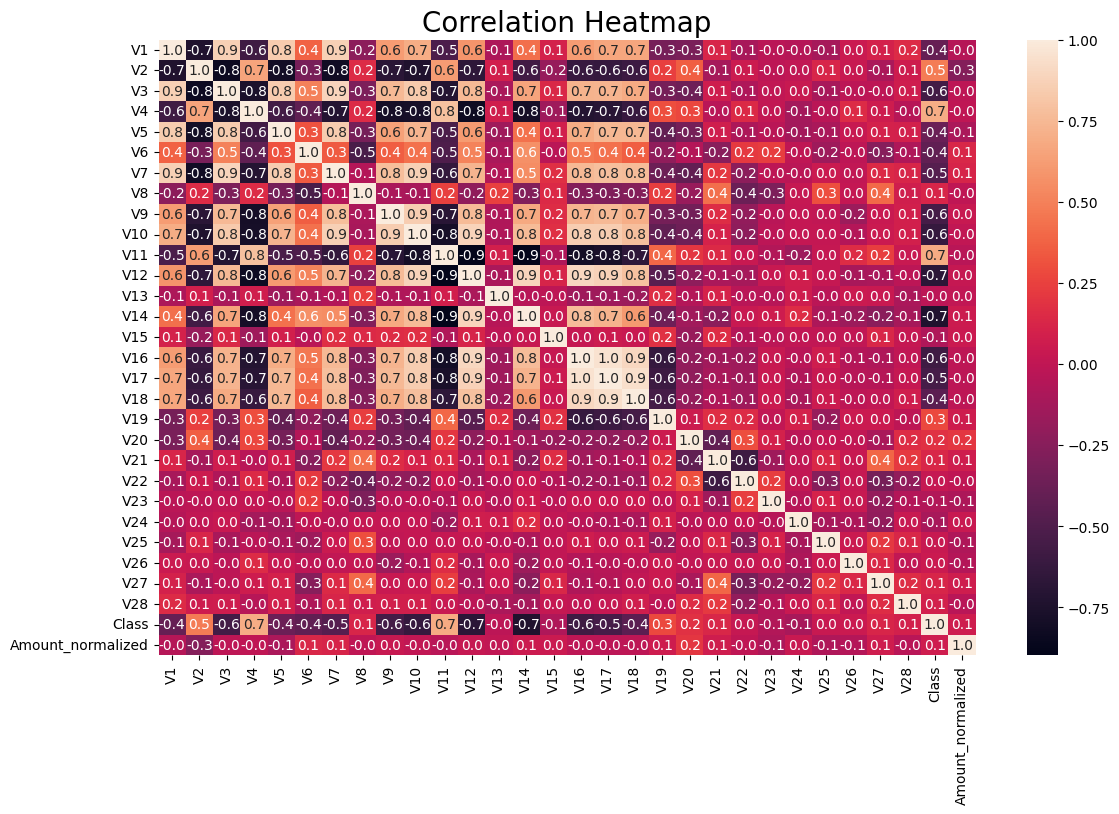

In [73]:
balanced_data = handle_imbalanced_data(df_scaled, method='under_sampling')
X = balanced_data.drop('Class', axis=1)
y = balanced_data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Compute the correlation matrix
corr_under_sampling = balanced_data.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_under_sampling, annot=True, fmt=".1f")
plt.tight_layout()

plt.title('Correlation Heatmap', fontsize=20)

In [65]:
# from sklearn.model_selection import GridSearchCV

# # Defining the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300, 400],
#     'max_depth': [1, 3, 5, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# rf = RandomForestClassifier()
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_ # best parameters of the search

# # Train the model and predict using the best parameters
# best_model = RandomForestClassifier(**best_params)
# best_model.fit(X_train, y_train)

# y_pred = best_model.predict(X_test)

# # Print the metrics
# print(f"Classification report for {best_model.__class__.__name__}: \n{classification_report(y_test, y_pred)}")
# print('Best params:', best_params)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Classification report for RandomForestClassifier: 
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       140
           1       1.00      0.91      0.95       144

    accuracy                           0.95       284
   macro avg       0.96      0.95      0.95       284
weighted avg       0.96      0.95      0.95       284

Best params: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [74]:
############################ TESTING ############################
best_params = {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

In [75]:
from sklearn.metrics import accuracy_score

# Train the model and predict using the best parameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = best_model.predict(X_train)

# Predict on the test set
y_test_pred = best_model.predict(X_test)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the metrics
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

if train_accuracy > test_accuracy:
    print("The model may be overfitting.")
elif train_accuracy < test_accuracy:
    print("The model may be underfitting.")
else:
    print("The model seems well-fitted.")

print(f"Classification report for {best_model.__class__.__name__}: \n{classification_report(y_test, y_test_pred)}")
print('Best params:', best_params)

Train Accuracy: 0.9531722054380665
Test Accuracy: 0.9471830985915493
The model may be overfitting.
Classification report for RandomForestClassifier: 
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       140
           1       0.98      0.91      0.95       144

    accuracy                           0.95       284
   macro avg       0.95      0.95      0.95       284
weighted avg       0.95      0.95      0.95       284

Best params: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


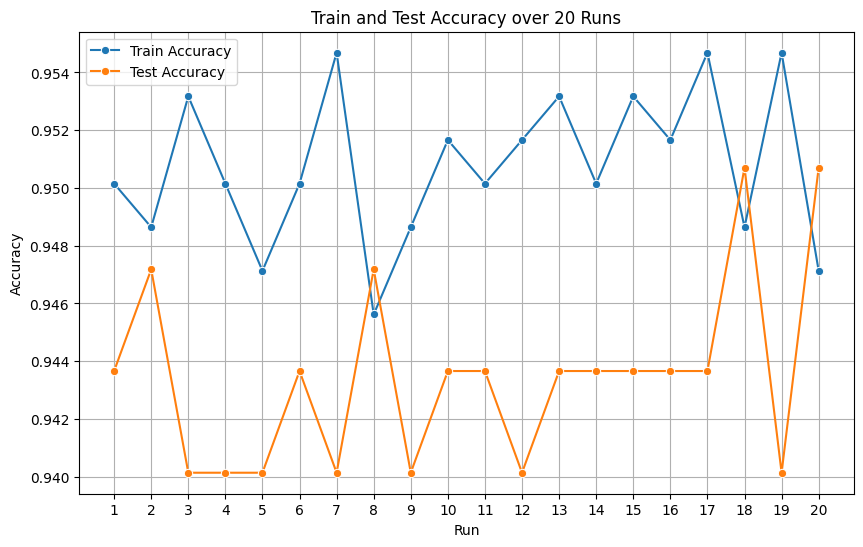

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lists to store accuracies
train_accuracies = []
test_accuracies = []

# Run the model 20 times
for i in range(20):
    # Train the model and predict using the best parameters
    best_model = RandomForestClassifier(**best_params, random_state=i)
    best_model.fit(X_train, y_train)

    # Predict on the training set
    y_train_pred = best_model.predict(X_train)

    # Predict on the test set
    y_test_pred = best_model.predict(X_test)

    # Calculate accuracy on the training set
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Calculate accuracy on the test set
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Append accuracies to the lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 21), y=train_accuracies, marker='o', label='Train Accuracy')
sns.lineplot(x=range(1, 21), y=test_accuracies, marker='o', label='Test Accuracy')
plt.title('Train and Test Accuracy over 20 Runs')
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.xticks(range(1, 21))
plt.legend()
plt.grid(True)
plt.show()

In [77]:
from sklearn.ensemble import RandomForestClassifier

# Fit a random forest to the data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances}) # Dataframe of importances
feature_importances = feature_importances.sort_values('importance', ascending=False) # sorting data
print(feature_importances[:18])

              feature  importance
9                 V10    0.155837
13                V14    0.110988
3                  V4    0.110855
11                V12    0.105253
10                V11    0.081640
16                V17    0.071730
6                  V7    0.058428
15                V16    0.042231
2                  V3    0.037076
1                  V2    0.022791
20                V21    0.021003
7                  V8    0.015954
28  Amount_normalized    0.015829
8                  V9    0.015769
18                V19    0.012421
4                  V5    0.012085
19                V20    0.010355
17                V18    0.010331


In [78]:
# Select the features with more than 3 significant decimals
top_features = feature_importances['feature'][feature_importances['importance'] > 10e-3]
print(top_features)

# Reduce X to the selected features
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

9                   V10
13                  V14
3                    V4
11                  V12
10                  V11
16                  V17
6                    V7
15                  V16
2                    V3
1                    V2
20                  V21
7                    V8
28    Amount_normalized
8                    V9
18                  V19
4                    V5
19                  V20
17                  V18
21                  V22
Name: feature, dtype: object


In [79]:
# Training model after feature selection
rf_reduced = RandomForestClassifier(random_state=42)
rf_reduced.fit(X_train_reduced, y_train)

# Predict on the test set
y_pred_reduced = rf_reduced.predict(X_test_reduced)

# Print the metrics
print(f"Classification report for {rf_reduced.__class__.__name__}: \n{classification_report(y_test, y_pred_reduced)}")

# Accuracy of the model and overfitting analysis
train_accuracy_reduced = accuracy_score(y_train, rf_reduced.predict(X_train_reduced))
test_accuracy_reduced = accuracy_score(y_test, y_pred_reduced)

print(f"Train Accuracy: {train_accuracy_reduced}")
print(f"Test Accuracy: {test_accuracy_reduced}")

Classification report for RandomForestClassifier: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       140
           1       0.98      0.91      0.94       144

    accuracy                           0.94       284
   macro avg       0.95      0.94      0.94       284
weighted avg       0.95      0.94      0.94       284

Train Accuracy: 1.0
Test Accuracy: 0.9436619718309859


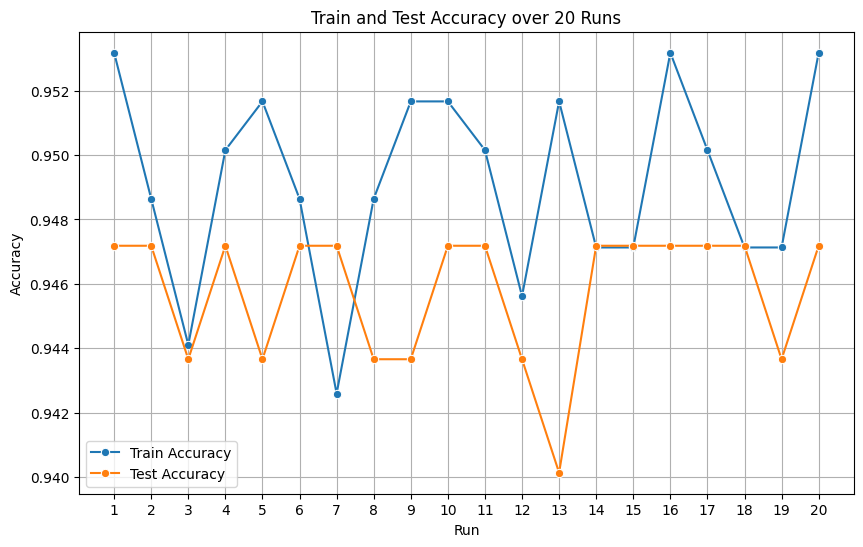

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lists to store accuracies
train_accuracies = []
test_accuracies = []

# Run the model 20 times
for i in range(20):
    rf_reduced = RandomForestClassifier(random_state=i, **best_params)
    rf_reduced.fit(X_train_reduced, y_train)

    # Accuracy of the model and overfitting analysis
    train_accuracy_reduced = accuracy_score(y_train, rf_reduced.predict(X_train_reduced))
    test_accuracy_reduced = accuracy_score(y_test, rf_reduced.predict(X_test_reduced))

    # Append accuracies to the lists
    train_accuracies.append(train_accuracy_reduced)
    test_accuracies.append(test_accuracy_reduced)

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 21), y=train_accuracies, marker='o', label='Train Accuracy')
sns.lineplot(x=range(1, 21), y=test_accuracies, marker='o', label='Test Accuracy')
plt.title('Train and Test Accuracy over 20 Runs')
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.xticks(range(1, 21))
plt.legend()
plt.grid(True)
plt.show()